# 1. Suicide Classificator Model

## 1.1 Import of libraries

In [44]:
%load_ext autotime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.metrics import recall_score, classification_report, accuracy_score, confusion_matrix
import random
import joblib as jb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 47 ms (started: 2022-09-01 13:30:47 -03:00)


## 1.2 Load of cleaned dataset

In [3]:
df = jb.load("df_cleaned.pkl.z")

df

,text,target
0,wife threatening suiciderecently left wife goo...,1
1,weird compliments coming irl feel good interne...,0
2,finally hear bad year swear fucking god annoying,0
3,helpjust crying hard,1
4,losthello adam ive struggling years afraid yea...,1
...,...,...
232069,rock,0
232070,friends lonely deprived prebought nightmares c...,0
232071,pee tastes salty tea‼ drank pee confirm this‼,0
232072,usual stuff hereim posting sympathy pity worse...,1


time: 1.06 s (started: 2022-09-01 09:53:22 -03:00)


# 2. Features extraction

## 2.1 Token based text embedding trained on English Google News 200B corpus

In [4]:
model_path = 'https://tfhub.dev/google/nnlm-en-dim128/2'

time: 0 ns (started: 2022-09-01 09:53:28 -03:00)


In [5]:
embed = hub.load(model_path)

time: 3.38 s (started: 2022-09-01 09:53:30 -03:00)


In [6]:
X = embed(df.text.values).numpy()
y = df["target"]

time: 3.81 s (started: 2022-09-01 09:53:38 -03:00)


In [7]:
X

array([[ 0.26429525,  0.3456967 , -0.22154205, ..., -0.19419369,
         0.38023242,  0.15015593],
       [ 0.04143006,  0.09606296,  0.13170788, ..., -0.162113  ,
         0.16539519,  0.03167877],
       [ 0.19575906,  0.02332053, -0.2035519 , ..., -0.24393761,
         0.2821051 ,  0.00964567],
       ...,
       [-0.23646525, -0.11253097, -0.01313196, ..., -0.20468803,
         0.04054433, -0.01651086],
       [ 0.25885803,  0.36435312,  0.17277673, ..., -0.58082116,
         0.57309633,  0.04810402],
       [ 0.15417284, -0.11165278,  0.0190792 , ..., -0.22667104,
         0.22037362, -0.00992222]], dtype=float32)

time: 0 ns (started: 2022-09-01 09:53:46 -03:00)


## 2.3 Splitting of data in train, validation and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.5, random_state = 0)

time: 187 ms (started: 2022-09-01 09:53:49 -03:00)


In [9]:
X_train

array([[ 0.04996134, -0.03333091,  0.05522839, ..., -0.10491034,
         0.08229201, -0.0775074 ],
       [ 0.10593665, -0.0341535 ,  0.12592036, ..., -0.13075879,
         0.25623295,  0.00978653],
       [-0.0266034 , -0.01543735, -0.2346773 , ..., -0.01892284,
         0.2683221 ,  0.03488593],
       ...,
       [ 0.02847032,  0.06935585, -0.04542333, ..., -0.29051492,
         0.02259191, -0.05520444],
       [ 0.0538406 , -0.02578355,  0.06965497, ..., -0.24526979,
         0.00276838, -0.12095176],
       [ 0.02696996,  0.07845993, -0.02011973, ..., -0.14961016,
        -0.01437266, -0.02137816]], dtype=float32)

time: 0 ns (started: 2022-09-01 09:53:52 -03:00)


# 3. Model

## 3.1 Logistic Regression
<br>

- Logistic regression is applied to avoid a further step to calibrate probabilities results

In [33]:
model = LogisticRegression(C = 1)

model.fit(X_train, y_train)

p_val = model.predict(X_val)

p_test = model.predict(X_test)

time: 1.58 s (started: 2022-09-01 13:12:30 -03:00)


## 3.2 XGBoost

### 3.2.1 Tunning

In [16]:
np.random.seed(0)

hyper_rs_xgb = { "learning_rate": np.arange(0.01, 1.01, 0.01)
                        , "n_estimators": range(500,1500)
                        , "colsample_bytree": np.arange(0.1, 1.1, 0.1)
                        , "max_depth": range(1, 10)
                        , "subsample": np.arange(0.1, 1.1, 0.1)
                        , "gamma": range(1,10)}

xgboost_rs = xgb.XGBClassifier(objective = "binary:logistic")

rs_xgb = RandomizedSearchCV(param_distributions = hyper_rs_xgb
                                    , estimator = xgboost_rs
                                    , scoring = "accuracy"
                                    , n_iter = 5, cv = 3, verbose = True)

evaluation = [(X_train, y_train), (X_val, y_val)]

rs_xgb.fit(X_train, y_train, early_stopping_rounds = 2, eval_metric = "auc", eval_set = evaluation, verbose = True)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[0]	validation_0-auc:0.86146	validation_1-auc:0.86094
[1]	validation_0-auc:0.88615	validation_1-auc:0.88405
[2]	validation_0-auc:0.90113	validation_1-auc:0.89846
[3]	validation_0-auc:0.90702	validation_1-auc:0.90395
[4]	validation_0-auc:0.91056	validation_1-auc:0.90704
[5]	validation_0-auc:0.91658	validation_1-auc:0.91268
[6]	validation_0-auc:0.92048	validation_1-auc:0.91609
[7]	validation_0-auc:0.92425	validation_1-auc:0.91947
[8]	validation_0-auc:0.92719	validation_1-auc:0.92216
[9]	validation_0-auc:0.92969	validation_1-auc:0.92444
[10]	validation_0-auc:0.93155	validation_1-auc:0.92626
[11]	validation_0-auc:0.93385	validation_1-auc:0.92833
[12]	validation_0-auc:0.93569	validation_1-auc:0.92987
[13]	validation_0-auc:0.93787	validation_1-auc:0.93173
[14]	validation_0-auc:0.93930	validation_1-auc:0.93285
[15]	validation_0-auc:0.94128	validation_1-auc:0.93461
[16]	validation_0-auc:0.94270	validation_1-auc:0.93575
[17]	validation

[54]	validation_0-auc:0.96273	validation_1-auc:0.94899
[55]	validation_0-auc:0.96313	validation_1-auc:0.94929
[56]	validation_0-auc:0.96340	validation_1-auc:0.94941
[57]	validation_0-auc:0.96376	validation_1-auc:0.94956
[58]	validation_0-auc:0.96406	validation_1-auc:0.94969
[59]	validation_0-auc:0.96435	validation_1-auc:0.94972
[60]	validation_0-auc:0.96454	validation_1-auc:0.94981
[61]	validation_0-auc:0.96472	validation_1-auc:0.94988
[62]	validation_0-auc:0.96502	validation_1-auc:0.94998
[63]	validation_0-auc:0.96514	validation_1-auc:0.95006
[64]	validation_0-auc:0.96541	validation_1-auc:0.95020
[65]	validation_0-auc:0.96562	validation_1-auc:0.95025
[66]	validation_0-auc:0.96583	validation_1-auc:0.95040
[67]	validation_0-auc:0.96608	validation_1-auc:0.95054
[68]	validation_0-auc:0.96631	validation_1-auc:0.95064
[69]	validation_0-auc:0.96646	validation_1-auc:0.95073
[70]	validation_0-auc:0.96666	validation_1-auc:0.95087
[71]	validation_0-auc:0.96680	validation_1-auc:0.95093
[72]	valid

[83]	validation_0-auc:0.96856	validation_1-auc:0.95161
[84]	validation_0-auc:0.96867	validation_1-auc:0.95162
[85]	validation_0-auc:0.96888	validation_1-auc:0.95169
[86]	validation_0-auc:0.96902	validation_1-auc:0.95174
[87]	validation_0-auc:0.96917	validation_1-auc:0.95177
[88]	validation_0-auc:0.96935	validation_1-auc:0.95183
[89]	validation_0-auc:0.96952	validation_1-auc:0.95189
[90]	validation_0-auc:0.96958	validation_1-auc:0.95189
[91]	validation_0-auc:0.96975	validation_1-auc:0.95195
[92]	validation_0-auc:0.96986	validation_1-auc:0.95197
[93]	validation_0-auc:0.97003	validation_1-auc:0.95199
[94]	validation_0-auc:0.97007	validation_1-auc:0.95205
[95]	validation_0-auc:0.97018	validation_1-auc:0.95211
[96]	validation_0-auc:0.97022	validation_1-auc:0.95215
[97]	validation_0-auc:0.97029	validation_1-auc:0.95218
[98]	validation_0-auc:0.97037	validation_1-auc:0.95218
[99]	validation_0-auc:0.97045	validation_1-auc:0.95223
[100]	validation_0-auc:0.97064	validation_1-auc:0.95229
[101]	val

[15]	validation_0-auc:0.94896	validation_1-auc:0.93219
[16]	validation_0-auc:0.94967	validation_1-auc:0.93246
[17]	validation_0-auc:0.95061	validation_1-auc:0.93293
[18]	validation_0-auc:0.95157	validation_1-auc:0.93308
[19]	validation_0-auc:0.95239	validation_1-auc:0.93339
[20]	validation_0-auc:0.95306	validation_1-auc:0.93367
[21]	validation_0-auc:0.95379	validation_1-auc:0.93325
[22]	validation_0-auc:0.95477	validation_1-auc:0.93389
[23]	validation_0-auc:0.95536	validation_1-auc:0.93420
[24]	validation_0-auc:0.95582	validation_1-auc:0.93415
[25]	validation_0-auc:0.95641	validation_1-auc:0.93390
[0]	validation_0-auc:0.87325	validation_1-auc:0.87174
[1]	validation_0-auc:0.89903	validation_1-auc:0.89681
[2]	validation_0-auc:0.91262	validation_1-auc:0.90881
[3]	validation_0-auc:0.92034	validation_1-auc:0.91541
[4]	validation_0-auc:0.92615	validation_1-auc:0.91962
[5]	validation_0-auc:0.93030	validation_1-auc:0.92236
[6]	validation_0-auc:0.93307	validation_1-auc:0.92390
[7]	validation_0-

[52]	validation_0-auc:0.88177	validation_1-auc:0.88305
[53]	validation_0-auc:0.88235	validation_1-auc:0.88364
[54]	validation_0-auc:0.88289	validation_1-auc:0.88421
[55]	validation_0-auc:0.88336	validation_1-auc:0.88467
[56]	validation_0-auc:0.88348	validation_1-auc:0.88478
[57]	validation_0-auc:0.88410	validation_1-auc:0.88532
[58]	validation_0-auc:0.88456	validation_1-auc:0.88578
[59]	validation_0-auc:0.88509	validation_1-auc:0.88632
[60]	validation_0-auc:0.88528	validation_1-auc:0.88647
[61]	validation_0-auc:0.88574	validation_1-auc:0.88698
[62]	validation_0-auc:0.88625	validation_1-auc:0.88746
[63]	validation_0-auc:0.88664	validation_1-auc:0.88776
[64]	validation_0-auc:0.88693	validation_1-auc:0.88798
[65]	validation_0-auc:0.88716	validation_1-auc:0.88818
[66]	validation_0-auc:0.88749	validation_1-auc:0.88848
[67]	validation_0-auc:0.88786	validation_1-auc:0.88889
[68]	validation_0-auc:0.88822	validation_1-auc:0.88923
[69]	validation_0-auc:0.88869	validation_1-auc:0.88968
[70]	valid

[200]	validation_0-auc:0.91307	validation_1-auc:0.91355
[201]	validation_0-auc:0.91321	validation_1-auc:0.91370
[202]	validation_0-auc:0.91337	validation_1-auc:0.91384
[203]	validation_0-auc:0.91346	validation_1-auc:0.91395
[204]	validation_0-auc:0.91360	validation_1-auc:0.91408
[205]	validation_0-auc:0.91367	validation_1-auc:0.91414
[206]	validation_0-auc:0.91392	validation_1-auc:0.91437
[207]	validation_0-auc:0.91393	validation_1-auc:0.91438
[208]	validation_0-auc:0.91416	validation_1-auc:0.91461
[209]	validation_0-auc:0.91442	validation_1-auc:0.91488
[210]	validation_0-auc:0.91441	validation_1-auc:0.91488
[211]	validation_0-auc:0.91443	validation_1-auc:0.91492
[212]	validation_0-auc:0.91452	validation_1-auc:0.91500
[213]	validation_0-auc:0.91456	validation_1-auc:0.91506
[214]	validation_0-auc:0.91465	validation_1-auc:0.91514
[215]	validation_0-auc:0.91464	validation_1-auc:0.91513
[216]	validation_0-auc:0.91486	validation_1-auc:0.91535
[217]	validation_0-auc:0.91506	validation_1-auc:

[44]	validation_0-auc:0.95799	validation_1-auc:0.94428
[45]	validation_0-auc:0.95827	validation_1-auc:0.94447
[46]	validation_0-auc:0.95845	validation_1-auc:0.94451
[47]	validation_0-auc:0.95872	validation_1-auc:0.94472
[48]	validation_0-auc:0.95897	validation_1-auc:0.94483
[49]	validation_0-auc:0.95917	validation_1-auc:0.94492
[50]	validation_0-auc:0.95937	validation_1-auc:0.94503
[51]	validation_0-auc:0.95964	validation_1-auc:0.94514
[52]	validation_0-auc:0.95996	validation_1-auc:0.94531
[53]	validation_0-auc:0.96022	validation_1-auc:0.94537
[54]	validation_0-auc:0.96049	validation_1-auc:0.94547
[55]	validation_0-auc:0.96086	validation_1-auc:0.94576
[56]	validation_0-auc:0.96107	validation_1-auc:0.94587
[57]	validation_0-auc:0.96130	validation_1-auc:0.94599
[58]	validation_0-auc:0.96153	validation_1-auc:0.94602
[59]	validation_0-auc:0.96179	validation_1-auc:0.94597
[0]	validation_0-auc:0.86315	validation_1-auc:0.86492
[1]	validation_0-auc:0.88550	validation_1-auc:0.88637
[2]	validati

[56]	validation_0-auc:0.96135	validation_1-auc:0.94719
[57]	validation_0-auc:0.96158	validation_1-auc:0.94720
[58]	validation_0-auc:0.96172	validation_1-auc:0.94735
[59]	validation_0-auc:0.96200	validation_1-auc:0.94749
[60]	validation_0-auc:0.96219	validation_1-auc:0.94755
[61]	validation_0-auc:0.96240	validation_1-auc:0.94765
[62]	validation_0-auc:0.96266	validation_1-auc:0.94768
[63]	validation_0-auc:0.96293	validation_1-auc:0.94781
[64]	validation_0-auc:0.96318	validation_1-auc:0.94780
[65]	validation_0-auc:0.96331	validation_1-auc:0.94789
[66]	validation_0-auc:0.96357	validation_1-auc:0.94794
[67]	validation_0-auc:0.96369	validation_1-auc:0.94789
[0]	validation_0-auc:0.86291	validation_1-auc:0.86225
[1]	validation_0-auc:0.88503	validation_1-auc:0.88158
[2]	validation_0-auc:0.89888	validation_1-auc:0.89494
[3]	validation_0-auc:0.90768	validation_1-auc:0.90425
[4]	validation_0-auc:0.91320	validation_1-auc:0.90951
[5]	validation_0-auc:0.91777	validation_1-auc:0.91427
[6]	validation_0

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76

time: 6min 48s (started: 2022-09-01 11:52:12 -03:00)


In [18]:
print("Random search cross validation results")
print("Best params: ", rs_xgb.best_params_)
print("Best AUC: ", np.sqrt(np.abs(rs_xgb.best_score_)))

Random search cross validation results
Best params:  {'subsample': 0.7000000000000001, 'n_estimators': 739, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 6, 'colsample_bytree': 0.30000000000000004}
Best AUC:  0.9394208545763326
time: 0 ns (started: 2022-09-01 12:06:28 -03:00)


In [24]:
model_1 = xgb.XGBClassifier(objective = "binary:logistic", 
                             seed = 0,
                             subsample = rs_xgb.best_params_["subsample"],
                             n_estimators = rs_xgb.best_params_["n_estimators"],
                             max_depth = rs_xgb.best_params_["max_depth"],
                             learning_rate = rs_xgb.best_params_["learning_rate"],
                             colsample_bytree = rs_xgb.best_params_["colsample_bytree"],
                             gamma = rs_xgb.best_params_["gamma"])

evaluation_model_1 = [(X_train, y_train), (X_val, y_val)]

model_1.fit(X_train, y_train, eval_metric = "auc", eval_set = evaluation_model_1, verbose = True)

resultados_xgb = model_1.evals_result()

[0]	validation_0-auc:0.86291	validation_1-auc:0.86225
[1]	validation_0-auc:0.88503	validation_1-auc:0.88158
[2]	validation_0-auc:0.89888	validation_1-auc:0.89494
[3]	validation_0-auc:0.90768	validation_1-auc:0.90425
[4]	validation_0-auc:0.91320	validation_1-auc:0.90951
[5]	validation_0-auc:0.91777	validation_1-auc:0.91427
[6]	validation_0-auc:0.92075	validation_1-auc:0.91719
[7]	validation_0-auc:0.92431	validation_1-auc:0.91996
[8]	validation_0-auc:0.92776	validation_1-auc:0.92300
[9]	validation_0-auc:0.92980	validation_1-auc:0.92491
[10]	validation_0-auc:0.93202	validation_1-auc:0.92672
[11]	validation_0-auc:0.93405	validation_1-auc:0.92833
[12]	validation_0-auc:0.93660	validation_1-auc:0.93047
[13]	validation_0-auc:0.93882	validation_1-auc:0.93218
[14]	validation_0-auc:0.94042	validation_1-auc:0.93344
[15]	validation_0-auc:0.94206	validation_1-auc:0.93464
[16]	validation_0-auc:0.94378	validation_1-auc:0.93617
[17]	validation_0-auc:0.94509	validation_1-auc:0.93725
[18]	validation_0-au

[149]	validation_0-auc:0.98198	validation_1-auc:0.95464
[150]	validation_0-auc:0.98211	validation_1-auc:0.95465
[151]	validation_0-auc:0.98226	validation_1-auc:0.95468
[152]	validation_0-auc:0.98229	validation_1-auc:0.95468
[153]	validation_0-auc:0.98239	validation_1-auc:0.95465
[154]	validation_0-auc:0.98251	validation_1-auc:0.95469
[155]	validation_0-auc:0.98266	validation_1-auc:0.95472
[156]	validation_0-auc:0.98281	validation_1-auc:0.95475
[157]	validation_0-auc:0.98288	validation_1-auc:0.95475
[158]	validation_0-auc:0.98296	validation_1-auc:0.95479
[159]	validation_0-auc:0.98312	validation_1-auc:0.95480
[160]	validation_0-auc:0.98321	validation_1-auc:0.95478
[161]	validation_0-auc:0.98328	validation_1-auc:0.95481
[162]	validation_0-auc:0.98336	validation_1-auc:0.95484
[163]	validation_0-auc:0.98352	validation_1-auc:0.95486
[164]	validation_0-auc:0.98368	validation_1-auc:0.95487
[165]	validation_0-auc:0.98371	validation_1-auc:0.95490
[166]	validation_0-auc:0.98383	validation_1-auc:

[296]	validation_0-auc:0.99101	validation_1-auc:0.95565
[297]	validation_0-auc:0.99105	validation_1-auc:0.95565
[298]	validation_0-auc:0.99111	validation_1-auc:0.95566
[299]	validation_0-auc:0.99113	validation_1-auc:0.95567
[300]	validation_0-auc:0.99113	validation_1-auc:0.95567
[301]	validation_0-auc:0.99116	validation_1-auc:0.95564
[302]	validation_0-auc:0.99120	validation_1-auc:0.95567
[303]	validation_0-auc:0.99123	validation_1-auc:0.95569
[304]	validation_0-auc:0.99127	validation_1-auc:0.95568
[305]	validation_0-auc:0.99130	validation_1-auc:0.95567
[306]	validation_0-auc:0.99130	validation_1-auc:0.95567
[307]	validation_0-auc:0.99133	validation_1-auc:0.95566
[308]	validation_0-auc:0.99139	validation_1-auc:0.95566
[309]	validation_0-auc:0.99140	validation_1-auc:0.95566
[310]	validation_0-auc:0.99143	validation_1-auc:0.95567
[311]	validation_0-auc:0.99143	validation_1-auc:0.95567
[312]	validation_0-auc:0.99146	validation_1-auc:0.95566
[313]	validation_0-auc:0.99148	validation_1-auc:

[443]	validation_0-auc:0.99433	validation_1-auc:0.95566
[444]	validation_0-auc:0.99436	validation_1-auc:0.95567
[445]	validation_0-auc:0.99436	validation_1-auc:0.95568
[446]	validation_0-auc:0.99440	validation_1-auc:0.95566
[447]	validation_0-auc:0.99441	validation_1-auc:0.95565
[448]	validation_0-auc:0.99445	validation_1-auc:0.95564
[449]	validation_0-auc:0.99445	validation_1-auc:0.95564
[450]	validation_0-auc:0.99449	validation_1-auc:0.95562
[451]	validation_0-auc:0.99449	validation_1-auc:0.95561
[452]	validation_0-auc:0.99450	validation_1-auc:0.95562
[453]	validation_0-auc:0.99451	validation_1-auc:0.95562
[454]	validation_0-auc:0.99454	validation_1-auc:0.95561
[455]	validation_0-auc:0.99456	validation_1-auc:0.95563
[456]	validation_0-auc:0.99456	validation_1-auc:0.95563
[457]	validation_0-auc:0.99455	validation_1-auc:0.95564
[458]	validation_0-auc:0.99457	validation_1-auc:0.95563
[459]	validation_0-auc:0.99458	validation_1-auc:0.95566
[460]	validation_0-auc:0.99459	validation_1-auc:

[590]	validation_0-auc:0.99605	validation_1-auc:0.95585
[591]	validation_0-auc:0.99605	validation_1-auc:0.95585
[592]	validation_0-auc:0.99605	validation_1-auc:0.95585
[593]	validation_0-auc:0.99605	validation_1-auc:0.95585
[594]	validation_0-auc:0.99606	validation_1-auc:0.95584
[595]	validation_0-auc:0.99606	validation_1-auc:0.95584
[596]	validation_0-auc:0.99609	validation_1-auc:0.95581
[597]	validation_0-auc:0.99609	validation_1-auc:0.95582
[598]	validation_0-auc:0.99610	validation_1-auc:0.95582
[599]	validation_0-auc:0.99611	validation_1-auc:0.95581
[600]	validation_0-auc:0.99611	validation_1-auc:0.95584
[601]	validation_0-auc:0.99614	validation_1-auc:0.95582
[602]	validation_0-auc:0.99617	validation_1-auc:0.95581
[603]	validation_0-auc:0.99618	validation_1-auc:0.95582
[604]	validation_0-auc:0.99618	validation_1-auc:0.95582
[605]	validation_0-auc:0.99618	validation_1-auc:0.95582
[606]	validation_0-auc:0.99619	validation_1-auc:0.95583
[607]	validation_0-auc:0.99620	validation_1-auc:

[737]	validation_0-auc:0.99683	validation_1-auc:0.95585
[738]	validation_0-auc:0.99683	validation_1-auc:0.95585
time: 4min 44s (started: 2022-09-01 12:19:11 -03:00)


In [21]:
p_val_1 = model_1.predict(X_val)

p_test_1 = model_1.predict(X_test)

time: 1.03 s (started: 2022-09-01 12:17:47 -03:00)


# 4. Results (hold-out)

## 4.1 Validation results - Logistic Regression

In [34]:
print(classification_report(y_val, p_val))
print("\n")
print("Recall Score: ", recall_score(y_val, p_val))
print("\n")
print(confusion_matrix(y_val, p_val))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     40646
           1       0.89      0.87      0.88     40580

    accuracy                           0.88     81226
   macro avg       0.88      0.88      0.88     81226
weighted avg       0.88      0.88      0.88     81226



Recall Score:  0.8679398718580582


[[36219  4427]
 [ 5359 35221]]
time: 250 ms (started: 2022-09-01 13:12:37 -03:00)


## 4.2 Validation results - XGBoost

In [27]:
print(classification_report(y_val, p_val_1))
print("\n")
print("Recall Score: ", recall_score(y_val, p_val_1))
print("\n")
print(confusion_matrix(y_val, p_val_1))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     40646
           1       0.89      0.89      0.89     40580

    accuracy                           0.89     81226
   macro avg       0.89      0.89      0.89     81226
weighted avg       0.89      0.89      0.89     81226



Recall Score:  0.8874322326269098


[[36254  4392]
 [ 4568 36012]]
time: 250 ms (started: 2022-09-01 13:04:36 -03:00)


## 4.3 Test results - Logistic Regression

In [35]:
print(classification_report(y_test, p_test))
print("\n")
print("Recall Score: ", recall_score(y_test, p_test))
print("\n")
print(confusion_matrix(y_test, p_test))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     34856
           1       0.89      0.87      0.88     34767

    accuracy                           0.88     69623
   macro avg       0.88      0.88      0.88     69623
weighted avg       0.88      0.88      0.88     69623



Recall Score:  0.8667414502257889


[[30985  3871]
 [ 4633 30134]]
time: 218 ms (started: 2022-09-01 13:12:41 -03:00)


## 4.4 Test results - XGBoost

In [29]:
print(classification_report(y_test, p_test_1))
print("\n")
print("Recall Score: ", recall_score(y_test, p_test_1))
print("\n")
print(confusion_matrix(y_test, p_test_1))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     34856
           1       0.89      0.89      0.89     34767

    accuracy                           0.89     69623
   macro avg       0.89      0.89      0.89     69623
weighted avg       0.89      0.89      0.89     69623



Recall Score:  0.8871631144476083


[[31056  3800]
 [ 3923 30844]]
time: 219 ms (started: 2022-09-01 13:04:43 -03:00)


# 5. Voting Classifier

In [37]:
models = [("m1", LogisticRegression(C = 1)),
             ("m2", xgb.XGBClassifier(objective = "binary:logistic", 
                             seed = 0,
                             subsample = rs_xgb.best_params_["subsample"],
                             n_estimators = rs_xgb.best_params_["n_estimators"],
                             max_depth = rs_xgb.best_params_["max_depth"],
                             learning_rate = rs_xgb.best_params_["learning_rate"],
                             colsample_bytree = rs_xgb.best_params_["colsample_bytree"],
                             gamma = rs_xgb.best_params_["gamma"]))]

time: 0 ns (started: 2022-09-01 13:15:57 -03:00)


In [41]:
ensemble = VotingClassifier(models, voting = "soft")

ensemble.fit(X_train, y_train)

p_val_2 = ensemble.predict(X_val)

p_test_2 = ensemble.predict(X_test)

time: 3min 36s (started: 2022-09-01 13:24:01 -03:00)


## 5.1 Validation results - Voting Classifier

In [42]:
print(classification_report(y_val, p_val_2))
print("\n")
print("Recall Score: ", recall_score(y_val, p_val_2))
print("\n")
print(confusion_matrix(y_val, p_val_2))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     40646
           1       0.90      0.89      0.89     40580

    accuracy                           0.89     81226
   macro avg       0.89      0.89      0.89     81226
weighted avg       0.89      0.89      0.89     81226



Recall Score:  0.8852636766880236


[[36609  4037]
 [ 4656 35924]]
time: 250 ms (started: 2022-09-01 13:29:42 -03:00)


## 5.2 Test results - Voting Classifier

In [43]:
print(classification_report(y_test, p_test_2))
print("\n")
print("Recall Score: ", recall_score(y_test, p_test_2))
print("\n")
print(confusion_matrix(y_test, p_test_2))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     34856
           1       0.90      0.89      0.89     34767

    accuracy                           0.89     69623
   macro avg       0.89      0.89      0.89     69623
weighted avg       0.89      0.89      0.89     69623



Recall Score:  0.8854948658210372


[[31353  3503]
 [ 3981 30786]]
time: 219 ms (started: 2022-09-01 13:29:45 -03:00)


# 6. Stacking Classifier

In [45]:
stacking = StackingClassifier(models, LogisticRegression(C = 1), passthrough = True)

stacking.fit(X_train, y_train)

p_val_3 = stacking.predict(X_val)

p_test_3 = stacking.predict(X_test)

time: 17min 49s (started: 2022-09-01 13:33:13 -03:00)


## 6.1 Validation results - Stacking

In [46]:
print(classification_report(y_val, p_val_3))
print("\n")
print("Recall Score: ", recall_score(y_val, p_val_3))
print("\n")
print(confusion_matrix(y_val, p_val_3))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     40646
           1       0.90      0.89      0.89     40580

    accuracy                           0.89     81226
   macro avg       0.89      0.89      0.89     81226
weighted avg       0.89      0.89      0.89     81226



Recall Score:  0.8879004435682603


[[36478  4168]
 [ 4549 36031]]
time: 250 ms (started: 2022-09-01 14:19:57 -03:00)


## 6.2 Test results - Stacking

In [47]:
print(classification_report(y_test, p_test_3))
print("\n")
print("Recall Score: ", recall_score(y_test, p_test_3))
print("\n")
print(confusion_matrix(y_test, p_test_3))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     34856
           1       0.90      0.89      0.89     34767

    accuracy                           0.89     69623
   macro avg       0.89      0.89      0.89     69623
weighted avg       0.89      0.89      0.89     69623



Recall Score:  0.8874507435211552


[[31270  3586]
 [ 3913 30854]]
time: 219 ms (started: 2022-09-01 14:20:52 -03:00)


# 7. Saving model

## 7.1 Model

In [48]:
import os

jb.dump(ensemble, "model_ensemble.pkl.z")

['model_ensemble.pkl.z']

time: 156 ms (started: 2022-09-01 14:22:39 -03:00)


# 8. Suicide risk classifier
<br>

### For an initial test, are considered 3 risk classes:
<br>

- Low probability (below 30%)
- Medium probability (between 30% and 60%)
- High probability (above 60%)

## 8.1 Prediction of probabilities

In [49]:
p_test_proba = ensemble.predict_proba(X_test)

time: 547 ms (started: 2022-09-01 14:22:54 -03:00)


In [50]:
p_test_proba[:,1]

array([0.99937091, 0.52663112, 0.08836235, ..., 0.02020309, 0.14254799,
       0.11202831])

time: 15 ms (started: 2022-09-01 14:23:01 -03:00)


## 8.2 Definition of classes according to probabilities

In [51]:
risk_class = np.where(p_test_proba[:,1] <= 0.3, "Low probability",
                 np.where(((p_test_proba[:,1] > 0.3) & (p_test_proba[:,1] <= 0.6)), "Medium probability", "High probability"))

time: 16 ms (started: 2022-09-01 14:23:06 -03:00)


In [52]:
risk_class

array(['High probability', 'Medium probability', 'Low probability', ...,
       'Low probability', 'Low probability', 'Low probability'],
      dtype='<U18')

time: 16 ms (started: 2022-09-01 14:23:08 -03:00)


## 8.3 Graphical results

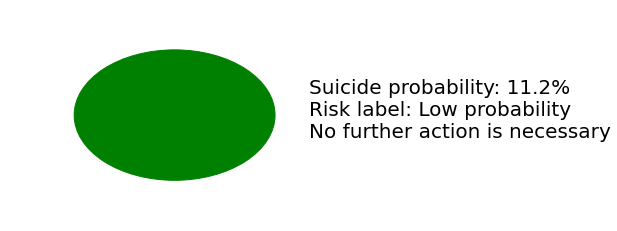

time: 438 ms (started: 2022-09-01 14:23:11 -03:00)


In [53]:
risk_label = risk_class[-1]

ax = plt.axes()

if risk_label == "Low probability":
    circle = plt.Circle((0.5, 0.5), 0.3, color='green')
    ax.text(0.9, 0.4, 'Suicide probability: {}%\nRisk label: {}\nNo further action is necessary'.format(round(p_test_proba[-1,1]*100, 2), risk_label), fontsize = 20)
elif risk_label == "Medium probability":
    circle = plt.Circle((0.5, 0.5), 0.3, color='yellow')
    ax.text(0.9, 0.4, 'Suicide probability: {}%\nRisk label: {}\nThe behavior must be closely monitored'.format(round(p_test_proba[-1,1]*100, 2), risk_label), fontsize = 20)
else:
    circle = plt.Circle((0.5, 0.5), 0.3, color='red')
    ax.text(0.9, 0.4, 'Suicide probability: {}%\nRisk label: {}\nDirect contact by a mental health professional required'.format(round(p_test_proba[-1,1]*100, 2), risk_label), fontsize = 20)

    
ax.add_patch(circle)

plt.axis("off")

plt.show()